In [123]:
from time import time

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

from sklearn.neighbors import NearestNeighbors

In [124]:
def wta(y, k):
    winners = np.argpartition(y, -k, axis=1)[:, -k:]
    idx = np.repeat(range(y.shape[0]), winners.shape[1]), winners.reshape(-1)
    yw = np.zeros(y.shape)
    yw[idx] = y[idx]
    return yw

def whiten(X, fudge=1E-18):
    Xcov = np.dot(X.T,X)
    d, V = np.linalg.eigh(Xcov)
    D = np.diag(1. / np.sqrt(d+fudge))
    W = np.dot(np.dot(V, D), V.T)
    X_white = np.dot(X, W)
    return X_white, W

def plot_weights(W):
    input_d = int(np.sqrt(W.shape[0]))
    hidden_d = int(np.sqrt(W.shape[1]))

    W_plot = np.zeros((input_d * hidden_d, input_d * hidden_d))
    i = 0
    for y in range(hidden_d):
        for x in range(hidden_d):
            W_plot[
                y*input_d:(y+1)*input_d,
                x*input_d:(x+1)*input_d
            ] = W[:, i].reshape(input_d, input_d)
            i += 1
    return shm(W_plot)

def shm(*matrices, **kwargs):
    plt.figure(1, figsize=(25,10))
    for m_id, matrix in enumerate(matrices):
        plt.subplot(len(matrices), 1, m_id+1)
        plt.imshow(np.squeeze(matrix).T, cmap='gray', origin='lower')
        plt.colorbar()

    if kwargs.get("file"):
        plt.savefig(kwargs["file"])
        plt.clf()
    else:
        plt.show()
    
def to_binary(x):
    return np.where(x > 0, 1.0, 0.0).astype(np.uint8)
        
def relu(x):
    return np.where(x > 0, x, 0.0)

def norm(w, factor=1.0):
    for i in range(w.shape[1]):
        w[:, i] = factor * w[:, i] / np.sqrt(np.sum(np.square(w[:,i])))

def weights_inner_product(W, p):
    return np.asarray([np.linalg.norm(W[:, ni], ord=p) for ni in range(W.shape[1])])

def shl(*vector, **kwargs):
    plt.figure(1, figsize=(15,10))
    labels = kwargs.get("labels", [])
    for id, v in enumerate(vector):
        if len(labels) > 0:
            plt.plot(np.squeeze(v), label=labels[id])
        else:
            plt.plot(np.squeeze(v))

    if len(labels) > 0:
        plt.legend()

    if kwargs.get("file"):
        plt.savefig(kwargs["file"])
        plt.clf()
    else:
        plt.show()

def patchefy(W, patch_size):
    orig_size = int(np.sqrt(W.shape[0]))

    Wo = W.reshape((orig_size, orig_size, W.shape[1]))
    Wc = np.zeros(Wo.shape)

    for ni in range(W.shape[1]):
        xp0 = random.randrange(0, orig_size-patch_size[0])
        yp0 = random.randrange(0, orig_size-patch_size[1])

        xp1 = xp0+patch_size[0]
        yp1 = yp0+patch_size[1]

        Wc[xp0:xp1, yp0:yp1, ni] = Wo[xp0:xp1, yp0:yp1, ni]

    return Wc.reshape(W.shape)

def top_k_ids(D, k):
    Di = np.argpartition(D, k, axis=1)
    if k > 0:
        Di_top = Di[:, :k]
    else:
        Di_top = Di[:, k:]
    Dv_top = np.take_along_axis(D, Di_top, axis=1)
    return np.take_along_axis(Di_top, np.argsort(Dv_top, axis=1), axis=1)


def query_coded(xc, yc, k):
    D = np.asarray([np.sum(ycv ^ xc, axis=1) for ycv in yc])
    return top_k_ids(D, k)

def overlaps(X, Y):
    assert X.shape[0] == Y.shape[0]
    return np.asarray([len(np.intersect1d(x, y)) for x, y in zip(X, Y)])

def quality(proposed, gt, number_of_neighbors):
    return np.mean(overlaps(proposed, gt) / number_of_neighbors)

def quality_coded(xc, yc, gt, k):
    return quality(query_coded(xc, yc, k), gt, k)

def knn(x, y, k, metric="euclidean"):
    nn = NearestNeighbors(k, algorithm="brute", metric=metric)
    nn.fit(x)
    return nn.kneighbors(y, k, return_distance=False)

In [125]:
class LSHCode(object):
    def __init__(self, input_dim, bit_code_length):
        self.bit_code_length = bit_code_length
        self.W = np.random.randn(input_dim, bit_code_length)
        
    def compute_code(self, x):
        assert self.W.shape[0] == x.shape[1],\
            "Expecting `{}` input dimensions, got `{}`".format(self.W.shape[0], x.shape[1])
        
        return to_binary(np.dot(x, self.W))

In [126]:
class HebbCode(object):
    def __init__(self, input_dim, bit_code_length, a=1.0):
        self.W = np.random.randn(input_dim, bit_code_length)
        self.bit_code_length = bit_code_length
        self.a = a

    def compute_code(self, x):
        y = self.a * relu(np.dot(x, self.W)) 
        return to_binary(y)

In [186]:
bit_code_length = 128
number_of_neighbors = 100

X = np.loadtxt("artist_train.csv", delimiter=",")
Y = np.loadtxt("artist_test.csv", delimiter=",")

input_dim = X.shape[1]

In [187]:
Xm = np.mean(X, axis=0)
Xvar = np.var(X, axis=0)

X = (X - Xm) / np.sqrt(Xvar + 0.01)
Y = (Y - Xm) / np.sqrt(Xvar + 0.01)

X, W_whiten = whiten(X, fudge=1e-05)
Y = np.dot(Y, W_whiten)

In [188]:
gt_res = knn(X, Y, number_of_neighbors)

In [189]:
lsh = LSHCode(input_dim, bit_code_length)
xc_lsh = lsh.compute_code(X)
yc_lsh = lsh.compute_code(Y)

lsh_res = query_coded(xc_lsh, yc_lsh, number_of_neighbors)

In [190]:
quality(lsh_res, gt_res, number_of_neighbors)

0.3557142857142857

In [200]:
np.random.seed(0)
theta = 0.0
a = 1.0
# a = 0.001
b = 1.0
epochs = 50
learning_rate = 0.1
init_learning_rate = 0.1
batch_size = 100
num_hidden = bit_code_length
number_of_train_batches = X.shape[0] // batch_size
number_of_test_batches = Y.shape[0] // batch_size
dt = 0.1
num_iter = 5
num_init_epochs = 0
k_win = int(0.2 * bit_code_length)

beta_norm = 0.1

alpha_res = 5.0
alpha_norm = 0.0001
W_max = 1.0
W_min = 0.0

tau_avg = 1000.0

W = np.random.normal(0.0, 1.0, (X.shape[1], num_hidden))
norm(W)
W_sign = np.sign(W)

R = np.zeros((num_hidden, num_hidden))
# R = 0.01 * np.abs(np.random.normal(0.0, 1.0, (num_hidden, num_hidden)))
np.fill_diagonal(R, 0)

W0 = W.copy()
R0 = R.copy()

In [201]:
y_stat = np.zeros((epochs, num_hidden))
converge_stat = np.zeros((epochs, 4))

y_avg = np.zeros((num_hidden,))
y_avg_stat = np.zeros((epochs, num_hidden))

X_res = np.zeros((X.shape[0], num_hidden,))
Y_res = np.zeros((Y.shape[0], num_hidden,))

for epoch in range(epochs):
    dW_norm = 0.0
    dR_norm = 0.0
    y_sparsity = 0.0
    
    t0 = time()
    learning_rate = init_learning_rate * (1-epoch / epochs)

    for i in range(number_of_train_batches):
        x = X[i*batch_size:(i+1)*batch_size,:]
        
        y = np.zeros((batch_size, num_hidden))
        u = np.zeros((batch_size, num_hidden))
        for _ in range(num_iter):
            du = np.dot(x, W) - np.dot(y, R)
            u += dt * du
            y = a * relu(u)
            
#         y = a * relu(np.dot(x, W) - theta)
#         y = wta(y, k_win)
        
        # statistics

        y_avg_cur = np.mean(y, 0)
        
        y_avg = (1.0 - 1.0 / tau_avg) * y_avg + (1.0 / tau_avg) * y_avg_cur
        y_avg_stat[epoch] += y_avg
        
        # statistics
        
        X_res[i*batch_size:(i+1)*batch_size,:] = y.copy()
        converge_stat[epoch, 2] += 1.0 - np.mean(np.count_nonzero(y, axis=1)) / y.shape[1] 
        # learning
        
        if epoch < num_init_epochs:
            continue

#         y_deriv = y * (y - y_avg)
        y_deriv = y

        # hard constraints logic
    
        dR = np.dot(y.T, y)        
        dW = np.dot(x.T, y_deriv) #- beta_norm * np.sum(y_deriv * y, 0, keepdims=True) * W
#         W_res = np.sum(np.abs(W), 0, keepdims=True)
#         dW = np.dot(x.T, y_deriv) - W_sign * alpha_norm * (W_res - alpha_res)

        
        dW_norm += np.linalg.norm(dW)
        dR_norm += np.linalg.norm(dR)
#         dW_norm += np.mean(W_res)
    
        W += learning_rate * dW
        R += learning_rate * dR
        np.fill_diagonal(R, 0)

#         W_abs = np.abs(W)
#         W = W_sign * np.where(W_abs > W_max, W_max, np.where(W_abs < W_min, W_min, W_abs))

    for i in range(number_of_test_batches):
        y_test = Y[i*batch_size:(i+1)*batch_size,:]

        y_res = np.zeros((batch_size, num_hidden))
        u_res = np.zeros((batch_size, num_hidden))
        for _ in range(num_iter):
            du = np.dot(y_test, W) - np.dot(y_res, R)
            u_res += dt * du
            y_res = a * relu(u_res)

#         y_res = a * relu(np.dot(y_test, W) - theta)
#         y_res = wta(y_res, k_win)
        
        Y_res[i*batch_size:(i+1)*batch_size,:] = y_res.copy()
    
    t1 = time()
    norm(W)
    
    y_avg_stat[epoch] /= number_of_train_batches

    converge_stat[epoch, 0] = dW_norm / number_of_train_batches
    converge_stat[epoch, 1] = dR_norm / number_of_train_batches
    converge_stat[epoch, 2] = converge_stat[epoch, 2] / number_of_train_batches

    
    if epoch % (epochs // 10) == 0 or epoch == epochs - 1:
        hebb_res = query_coded(to_binary(X_res), to_binary(Y_res), number_of_neighbors)
        q = quality(hebb_res, gt_res, number_of_neighbors)
        converge_stat[epoch, 3] = q

#         hebb_res = query_coded(to_binary(X_res), to_binary(Y_res), number_of_neighbors)
#         q = quality(hebb_res, gt_res, number_of_neighbors)
#         q = np.nan
        print(
            "Epoch {} "
            "|dW| = {:.3f} "
            "ex(W) = {:.3f},{:.3f} "
            "|W| = {:.3f} "
            "|dR| = {:.3f} "
            "<y> = {:.3f} q = {:.3f} sp = {:.1f}% ({:.3f}s)".format(
            epoch, 
            converge_stat[epoch, 0],
            np.min(W),
            np.max(W),
            weights_inner_product(W, 2)[0],
            converge_stat[epoch, 1],
            np.mean(y_stat[epoch]),
            q,
            100.0 * converge_stat[epoch, 2],
            t1-t0
            #np.mean(weights_inner_product(W, 2))
        ))     

Epoch 0 |dW| = 0.048 ex(W) = -0.529,0.518 |W| = 1.000 |dR| = 0.059 <y> = 0.000 q = 0.359 sp = 51.2% (0.227s)
Epoch 10 |dW| = 0.040 ex(W) = -0.514,0.520 |W| = 1.000 |dR| = 0.034 <y> = 0.000 q = 0.363 sp = 61.3% (0.173s)
Epoch 20 |dW| = 0.036 ex(W) = -0.512,0.523 |W| = 1.000 |dR| = 0.027 <y> = 0.000 q = 0.368 sp = 65.8% (0.169s)
Epoch 30 |dW| = 0.034 ex(W) = -0.511,0.525 |W| = 1.000 |dR| = 0.023 <y> = 0.000 q = 0.371 sp = 68.5% (0.162s)
Epoch 40 |dW| = 0.033 ex(W) = -0.511,0.526 |W| = 1.000 |dR| = 0.021 <y> = 0.000 q = 0.372 sp = 70.2% (0.163s)
Epoch 50 |dW| = 0.032 ex(W) = -0.510,0.528 |W| = 1.000 |dR| = 0.019 <y> = 0.000 q = 0.373 sp = 71.5% (0.165s)
Epoch 60 |dW| = 0.031 ex(W) = -0.509,0.529 |W| = 1.000 |dR| = 0.018 <y> = 0.000 q = 0.372 sp = 72.4% (0.171s)
Epoch 70 |dW| = 0.031 ex(W) = -0.509,0.530 |W| = 1.000 |dR| = 0.017 <y> = 0.000 q = 0.373 sp = 73.0% (0.169s)
Epoch 80 |dW| = 0.031 ex(W) = -0.509,0.531 |W| = 1.000 |dR| = 0.017 <y> = 0.000 q = 0.373 sp = 73.4% (0.168s)
Epoch 90 |d

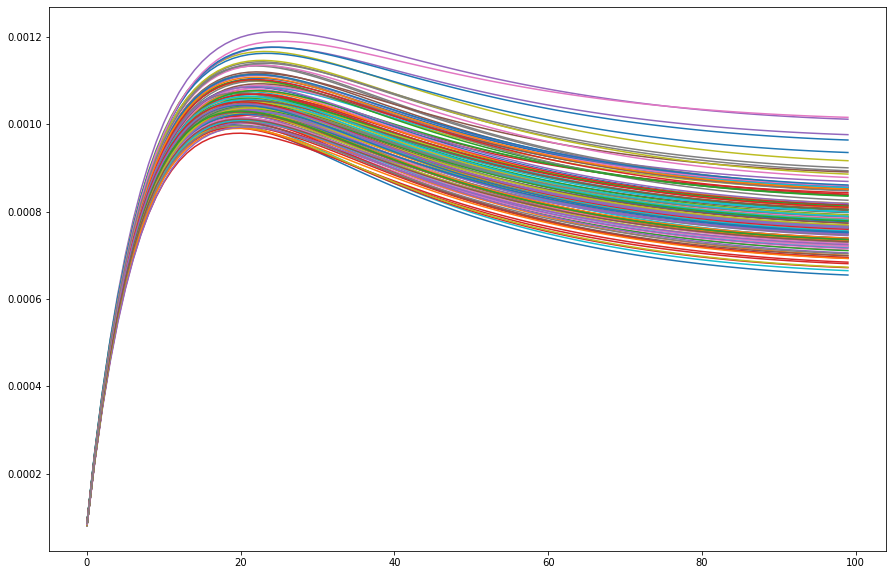

In [203]:
shl(y_avg_stat)

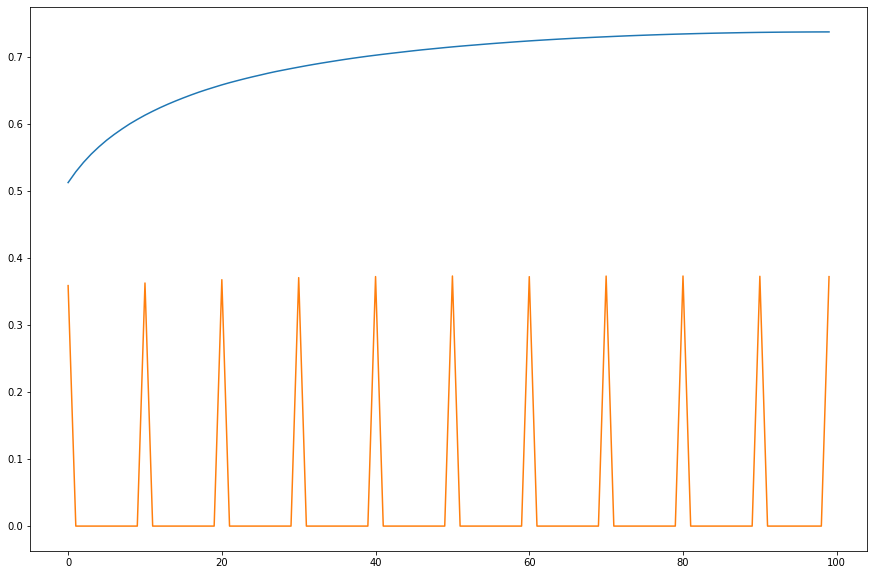

In [204]:
shl(converge_stat[:,2], converge_stat[:,3])

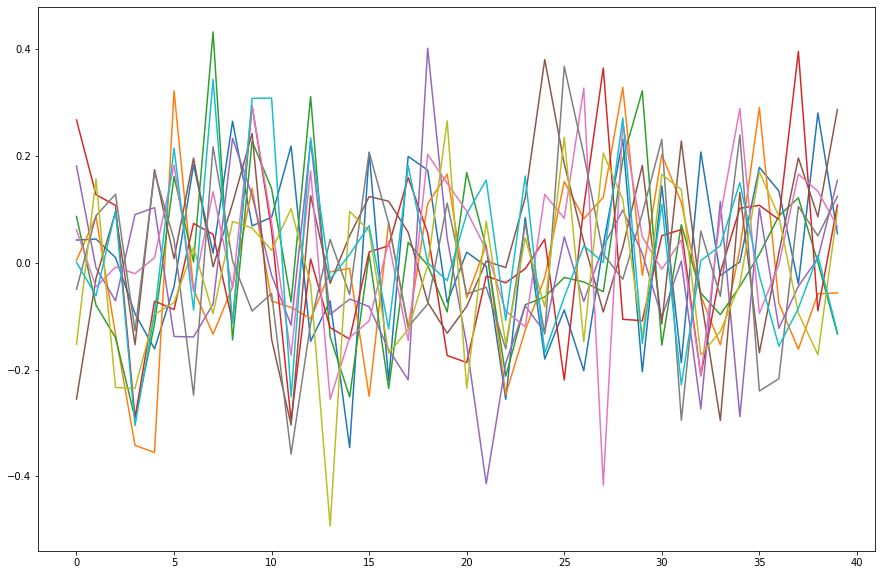

In [168]:
shl(W[:, np.arange(0, 10)])

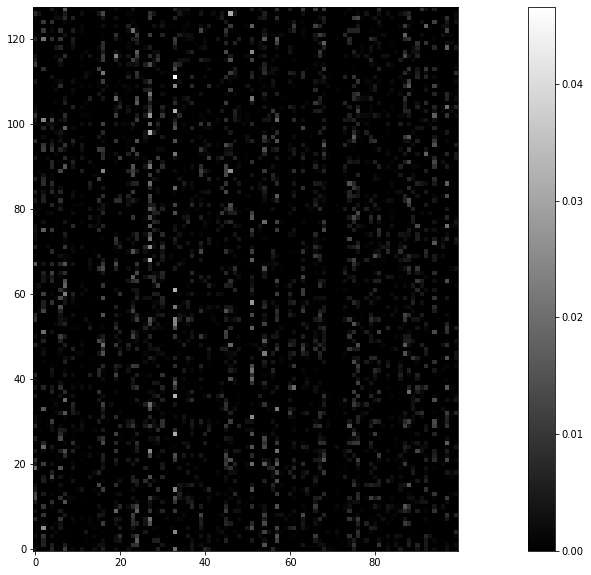

In [169]:
shm(y)

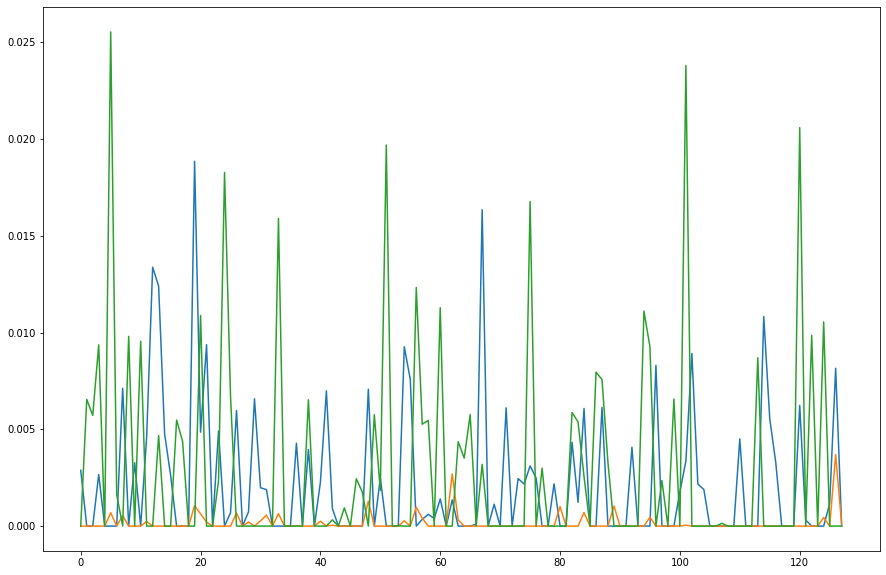

In [170]:
shl(y[(0,1,2), :].T)

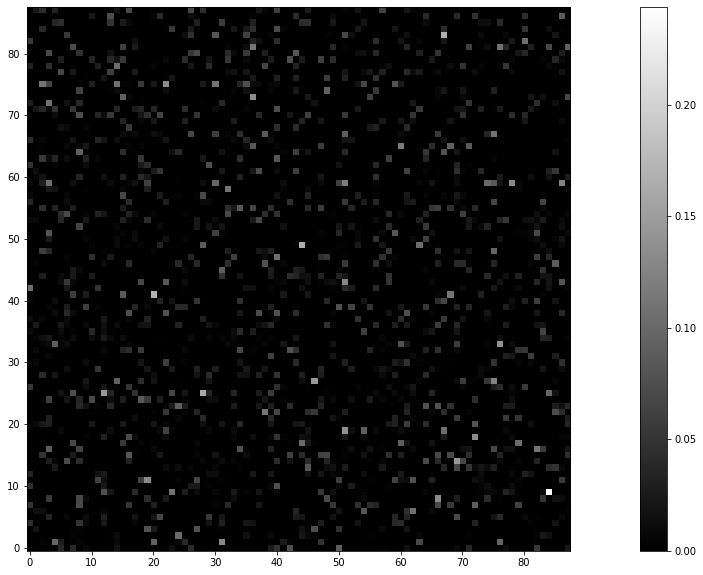

In [50]:
plot_weights(y[:64])

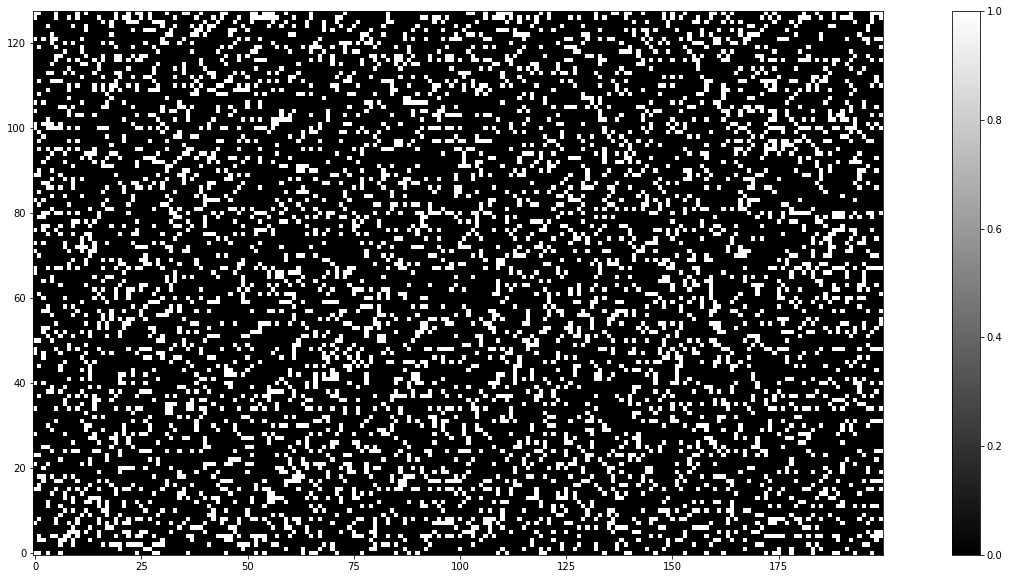

In [51]:
shm(to_binary(X_res)[:200])

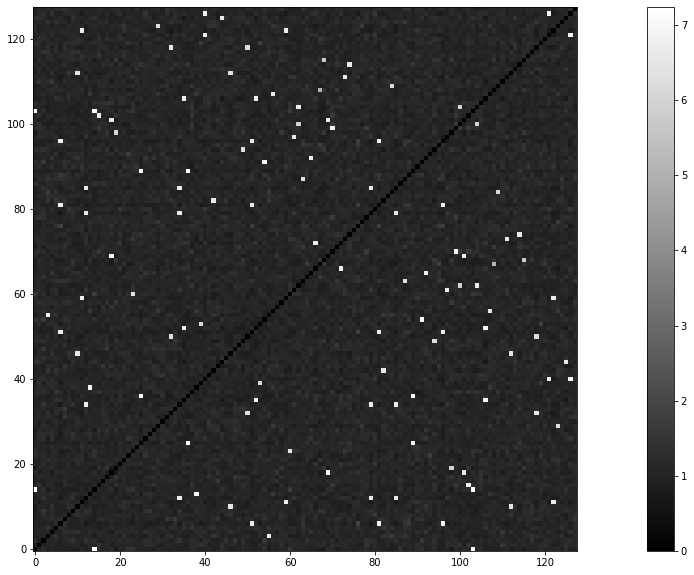

In [350]:
shm(R)